# Predict Pneumonia on X-ray using Deep Learning Techniques

### Fahad Almuqhim and Prasad Bhoite

#### CAP5610: Introduction of Machine Learning - Summer 2020
#### School of Computing and Information Sciences
#### Florida International University (FIU)

## Import the required libraries

In [1]:
%matplotlib inline
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2  #cv2. imread() method loads an image from the specified file.
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib # For data compression
import sklearn
import itertools  #functions creating iterators for efficient looping
import scipy
import skimage  # Library for image processing
from skimage.transform import resize
import csv
from tqdm import tqdm   #This make our loops show a smart progress meter - We just have to wrap any iterable with tqdm(iterable), and We're done!

from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers

from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


Bad key "text.kerning_factor" on line 4 in
/Users/falmuqhim/opt/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


#### Make sure you change the directory to the dataset

In [2]:
data_dir = 'chest_xray'

# Dataset Folder Structure:
* Our data is located in three folders:
* train: contains the training data/images for teaching our model.
* val: contains images which we will use to validate our model. The purpose of this data set is to prevent our model from Overfitting. Overfitting is when your model gets a little too comofortable with the training data and can't handle data it hasn't see....too well.
* test: this contains the data that we use to test the model once it has learned the relationships between the images and their label (Pneumonia/Not-Pneumonia)

In [4]:
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(data_dir + '/train/')
X_test, y_test= get_data(data_dir + '/test/')

100%|██████████| 234/234 [02:11<00:00,  1.78it/s]


## Helper functions

#### This function is to retrieve the model checkpoints in order to find the history while training the model

In [5]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#### This function is plot the learning curve that represent accuracy vs epoch number

In [6]:
def plotLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

#### This function is to print the confusion matrix 

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### This function is to plot learning curve for model accuracy and model loss

In [8]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

#### This function is to train, evaluate and test the given model 

In [9]:
def trainModel(xtrain,ytrain,xtest,ytest,base_model,numclasses,numepochs,labels):
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    
    
    # Add the top layers (input and output)
    predictions = Dense(numclasses, activation='softmax')(Flatten()(base_model.output))
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    # Fit the model
    history = model.fit(xtrain,ytrain, epochs=numepochs, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    
    # Evaluate the model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - loss:', score[0],'\n')
    print('\nKeras CNN - accuracy:', score[1],'\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest == 1)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

### Encoding categorical values using One Hot Encoding

In [10]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [11]:
print("Shape of X train:",X_train.shape)
print("Shape of X test:",X_test.shape)
print("Shape of y train:",y_train.shape)
print("Shape of y test:",y_test.shape)
classes = {0: 'Pneumonia', 1: 'Non Pneumonia'}

Shape of X train: (5216, 150, 150, 3)
Shape of X test: (624, 150, 150, 3)
Shape of y train: (5216, 2)
Shape of y test: (624, 2)


### Show some X-rays of normal patients

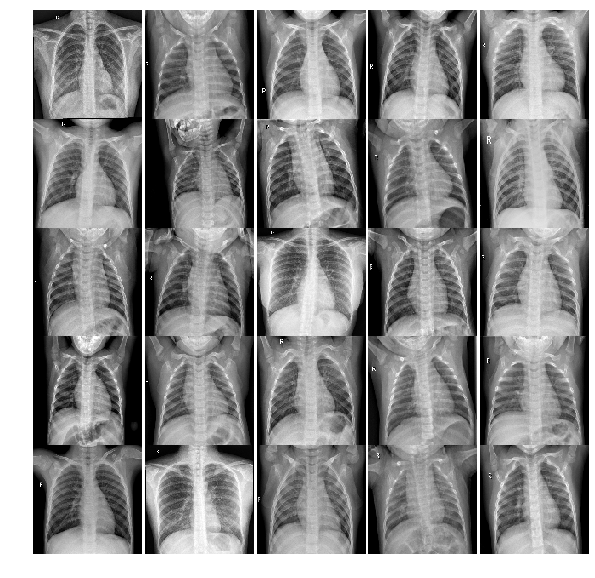

In [12]:
multipleImages = glob("chest_xray/train/NORMAL/**")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

### Show some X-rays of Pneumonia patients

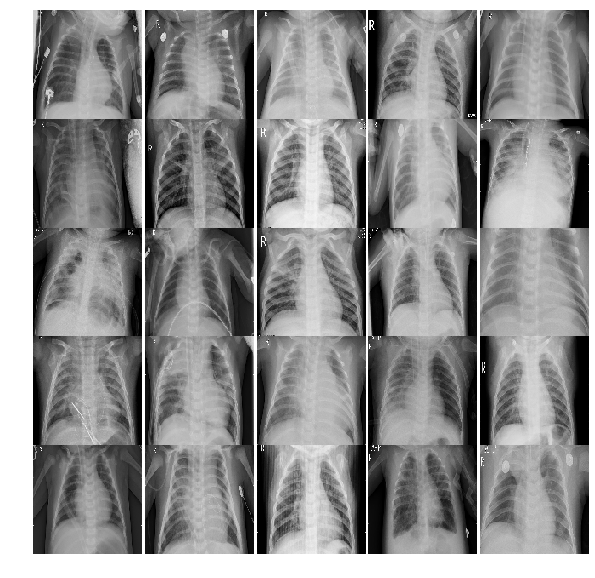

In [13]:
multipleImages = glob("chest_xray/train/PNEUMONIA/**")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

### Is the data balanced?

One of the most important process when preprocessing the data is to make sure that the data is balanced. This means the number of samples in each class is equal or almost equal.

Normal: 0 Pneumonia: 1


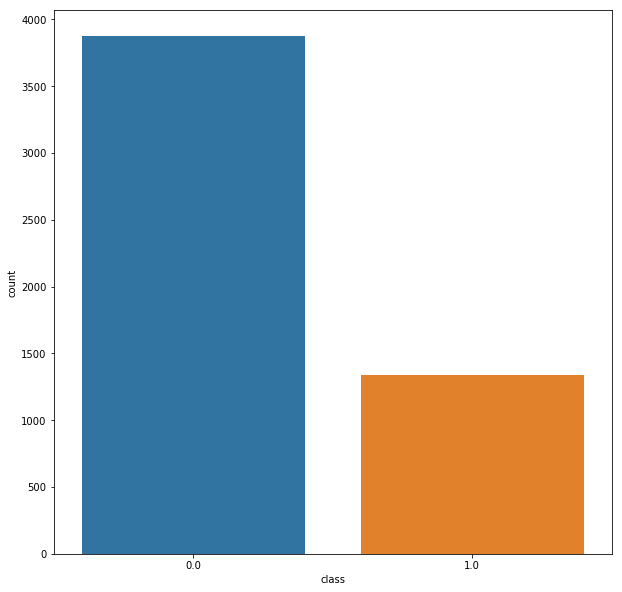

In [14]:
print('Normal: 0', 'Pneumonia: 1')
sns.countplot(x='class', data=pd.DataFrame({'class': [item[0] for item in y_train]}))

The above bar chart can clearly show that the dataset is imbalanced. There are 3875 samples of Pneumonia X-rays, and there are 1341 samples of non Pneumonia X-rays. There are several ways to solve this issue which include undersampling or generating synthetic data. In this case of data which is X-ray, the simple way to deal with that is to so undersampling show can be done by the following 

In [15]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods

X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
ros = RandomUnderSampler()
X_train, y_train = ros.fit_sample(X_trainFlat, Y_train)
X_test, y_test = ros.fit_sample(X_testFlat, Y_test)

y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
# Make Data 2D again
for i in range(len(X_train)):
    height, width, channels = 150,150,3
    X_train = X_train.reshape(len(X_train),height,width,channels)
for i in range(len(X_test)):
    height, width, channels = 150,150,3
    X_test = X_test.reshape(len(X_test),height,width,channels)


/Users/falmuqhim/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/falmuqhim/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Show sample count of each class

Normal: 0 Pneumonia: 1


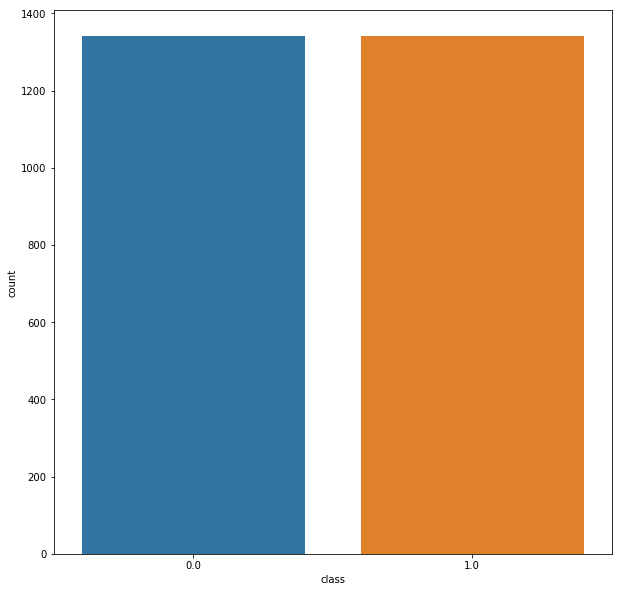

In [24]:
print('Normal: 0', 'Pneumonia: 1')
sns.countplot(x='class', data=pd.DataFrame({'class': [item[0] for item in y_train]}))

From the above bar chart, it shows that each class has 1341 samples

### Create pretrained model for each of our models which are

* VGG16 Model
* InceptionV3 Model
* ResNet50 Model

In [17]:
VGG16_model = VGG16(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
InceptionV3_model = InceptionV3(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))
ResNet50_model = ResNet50(weights = "imagenet", include_top=False, input_shape=(150, 150, 3))

In [18]:
num_epochs = 6

### Train, test and validate VGG16 model

In [19]:
print("Shape of X train:",X_train.shape)
print("Shape of X test:",X_test.shape)
print("Shape of y train:",y_train.shape)
print("Shape of y test:",y_test.shape)

Shape of X train: (2682, 150, 150, 3)
Shape of X test: (468, 150, 150, 3)
Shape of y train: (2682, 2)
Shape of y test: (468, 2)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

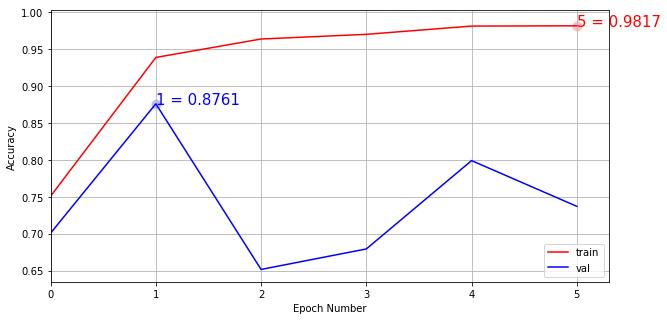

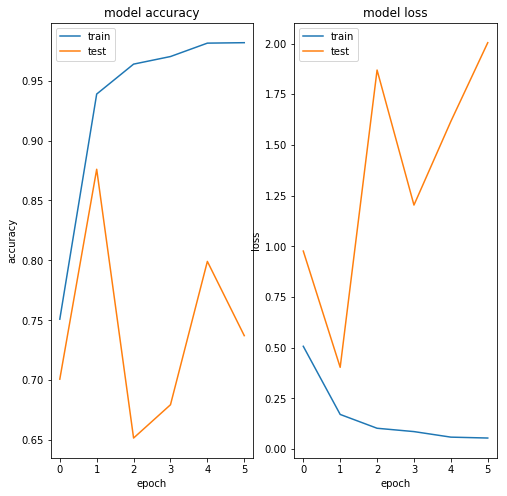

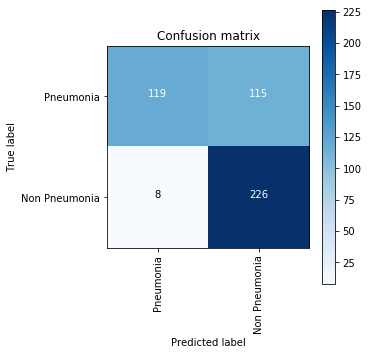

In [20]:
trainModel(X_train, y_train, X_test, y_test,VGG16_model,2,num_epochs,classes)

### Train, test and validate InceptionV3 model

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Epoch 1/6
84/84 [==============================] - 285s 3s/step - loss: 0.1817 - accuracy: 0.9325 - val_loss: 0.6698 - val_accuracy: 0.8568
Epoch 2/6
84/84 [==============================] - 273s 3s/step - loss: 0.0510 - accuracy: 0.9847 - val_loss: 1.1904 - val_accuracy: 0.7863
Epoch 3/6
84/84 [==============================] - 273s 3s/step - loss: 0.0314 - accuracy: 0.9903 - val_loss: 3.8402 - val_accuracy: 0.6581
Epoch 4/6
84/84 [==============================] - 273s 3s/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 1.5028 - val_accuracy: 0.8034
Epoch 5/6
84/84 [==============================] - 275s 3s/step - loss: 0.0103 - accuracy: 0.9963 - val_loss: 3.0368 - val_accuracy: 0.6581
Epoch 6/6
84/84 [==============================] - 274s 3s/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 3.3435 - val_accuracy: 0.7073

Keras CNN - loss: 3.343477964401245 


Keras CNN - accuracy: 0.7072649598121643 


               precision    recall  f1-score   support

    Pneumonia       

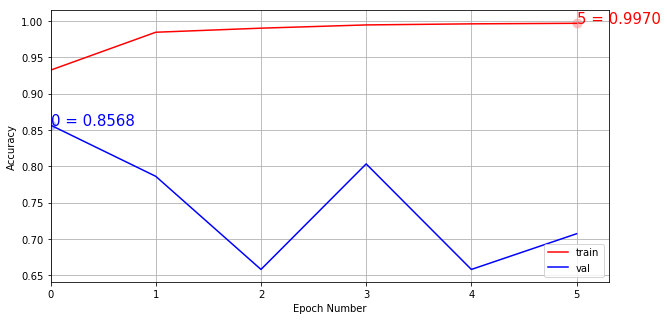

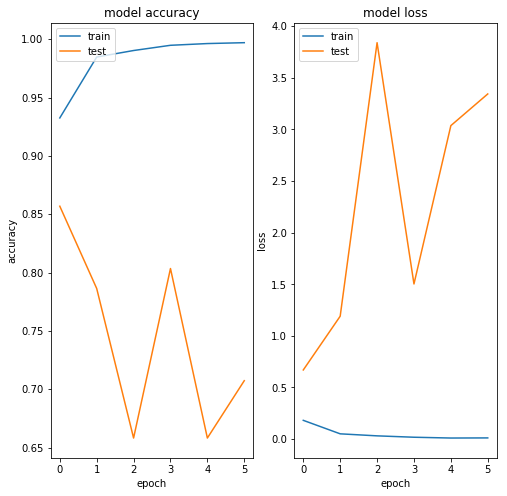

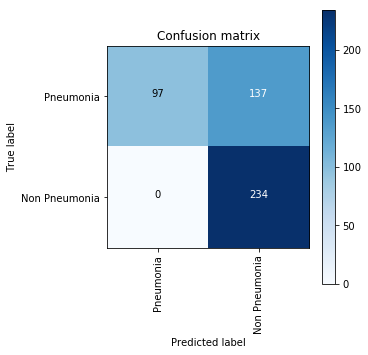

In [22]:
trainModel(X_train, y_train, X_test, y_test,InceptionV3_model,2,num_epochs,classes)

### Train, test and validate ResNet50 model

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

Epoch 1/6
84/84 [==============================] - 509s 6s/step - loss: 0.2239 - accuracy: 0.9448 - val_loss: 4.9074 - val_accuracy: 0.5000
Epoch 2/6
84/84 [==============================] - 513s 6s/step - loss: 0.1192 - accuracy: 0.9773 - val_loss: 1.6101 - val_accuracy: 0.5000
Epoch 3/6
84/84 [==============================] - 511s 6s/step - loss: 0.0401 - accuracy: 0.9855 - val_loss: 57.4128 - val_accuracy: 0.5000
Epoch 4/6
84/84 [==============================] - 515s 6s/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 43.8174 - val_accuracy: 0.5000
Epoch 5/6
84/84 [==============================] - 510s 6s/step - loss: 0.0122 - accuracy: 0.9978 - val_loss: 34.6354 - val_accuracy: 0.5385
Epoch 6/6
84/84 [==============================] - 514s 6s/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 28.1802 - val_accuracy: 0.5662

Keras CNN - loss: 28.18017578125 


Keras CNN - accuracy: 0.5662392973899841 


               precision    recall  f1-score   support

    Pneumonia      

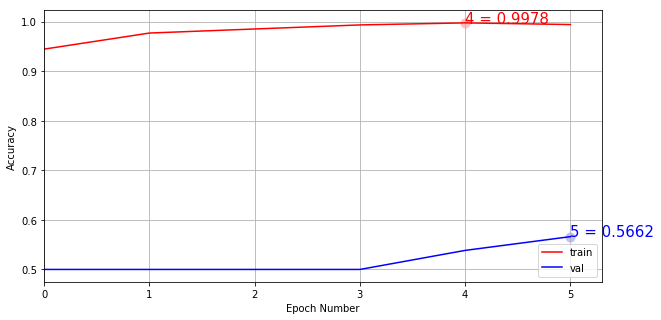

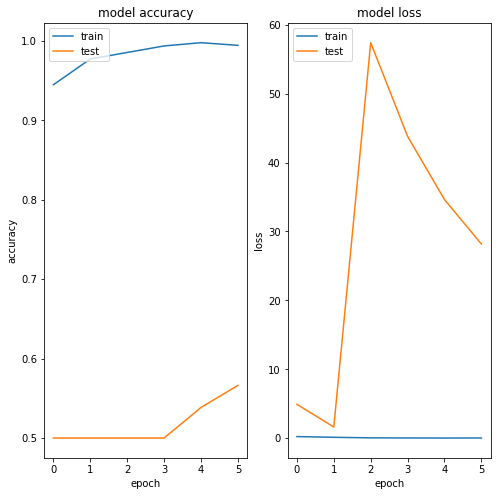

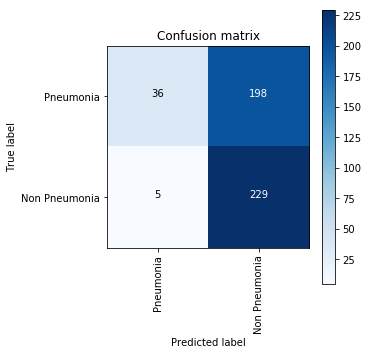

In [23]:
trainModel(X_train, y_train, X_test, y_test,ResNet50_model,2,num_epochs,classes)